In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Adding Features

In [51]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index_standardized.csv")
# Concat the index data with features - Q1 1998 - Q4 2019
Marco_folder = "../data/Features_Marco"
Micro_folder = "../data/updatest"
csv_file_pattern = "*.csv"
Marco_csv_files = glob.glob(f"{Marco_folder}/{csv_file_pattern}")
Micro_csv_files = glob.glob(f"{Micro_folder}/{csv_file_pattern}")

#Marco
# Iterate over each CSV file in Marco_csv_files
for file in Marco_csv_files:
    data = pd.read_csv(file)
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
    # Rename the 'Percentage Change' column to the index value
    data.rename(columns={'Percentage Change': new_name}, inplace=True)
    
    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(data,
                                     how='left',
                                     left_on='Quarter',
                                     right_on='Quarter')


#Micro
# Iterate over each CSV file in csv_files
for file in Micro_csv_files:
    data = pd.read_csv(file)

    # Extract the header row and separate the index values
    header = data.columns[1:]  # Assuming the index values are in columns except the first one
    index_values = header.tolist()
    
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
            
    # Create lists for the three columns
    quarter_column = []
    index_column = []
    file_name_column = []

    # Iterate through the data rows
    for row in data.itertuples(index=False):
        quarter = row[0]  # Extract the quarter value
        values = row[1:]  # Extract the values in the row

        # Iterate through the values and extract index and file name
        for index, file_name in zip(index_values, values):
            # Append the values to their respective columns
            quarter_column.append(quarter)
            index_column.append(index)
            file_name_column.append(file_name)

        
    # Create a DataFrame from the columns
    df = pd.DataFrame({'Quarter': quarter_column, 'index': index_column, new_name: file_name_column})


    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(df,
                                        how='left',
                                        left_on=['Quarter', 'index'],
                                        right_on=['Quarter', 'index'])

# Define quarters
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

     volatility      index  crash_label  price_change  volume_change  \
0     -0.628541  000001.SS            0      0.187709      -0.127147   
1     -0.628541  000001.SS            0      0.504913      -0.127147   
2     -0.625680  000001.SS            1     -0.795446      -0.127147   
3     -0.631403  000001.SS            0     -0.843210      -0.127147   
4     -0.629515  000001.SS            0     -0.082838      -0.127147   
..          ...        ...          ...           ...            ...   
875   -0.493234      ^SSMI            0     -0.800378      -0.127147   
876   -0.529809      ^SSMI            0      0.914383      -0.127147   
877   -0.458321      ^SSMI            0      0.217264      -0.127147   
878   -0.388212      ^SSMI            0     -0.010617      -0.127147   
879   -0.351813      ^SSMI            0      0.296414      -0.127147   

           date  Quarter  Crude_Oil_Index_Excess_Return_Quarterly  \
0    1998-03-31  Q1 1998                                -0.159831 

## Z-Score Standardization


In [52]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)
# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

['volatility', 'price_change', 'volume_change', 'Crude_Oil_Index_Excess_Return', 'Ted_Rate', 'Gold_Price', 'housing', 'reserve', '10YGov_BondYield', 'current_acct', 'FX_Rate', 'turnover', 'Population', 'npl', 'Recession_Indicators', 'inflation', 'Unemployment', 'GDP']


In [53]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

In [54]:
# Save the merge_file DataFrame to a CSV file
labeled_index.to_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv", index=False)

## Build the model

In [61]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
        grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
    
    # Train the model
    model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.1

[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................

[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C

[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................

In [62]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[52, 16], [2, 0]]",0.000000,0.000000,0.000000,...,-10.745291,4.267479,0.327179,0.809775,1.086359,-0.178086,0.797313,4.267479,-0.376667,0.664243
1,1998-03-31,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[20, 22], [7, 21]]",0.488372,0.750000,0.591549,...,-4.783840,2.530645,0.685769,0.639765,0.583536,-0.509120,0.883717,2.530645,0.060470,0.277351
2,1998-03-31,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[46, 18], [0, 6]]",0.250000,1.000000,0.400000,...,-1.861748,-0.336318,0.239436,0.045151,0.337729,-0.289952,0.574528,-0.336318,-0.142659,0.204832
3,1998-03-31,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[41, 18], [3, 8]]",0.307692,0.727273,0.432432,...,-1.560781,-1.542306,0.240107,0.060281,0.222206,0.075879,0.448031,-1.542306,-0.189073,0.131020
4,1998-03-31,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[57, 12], [0, 1]]",0.076923,1.000000,0.142857,...,-0.152355,0.070053,0.020343,0.132143,0.312485,0.162028,0.550049,0.070053,-0.209068,-0.027105


## Shap Values

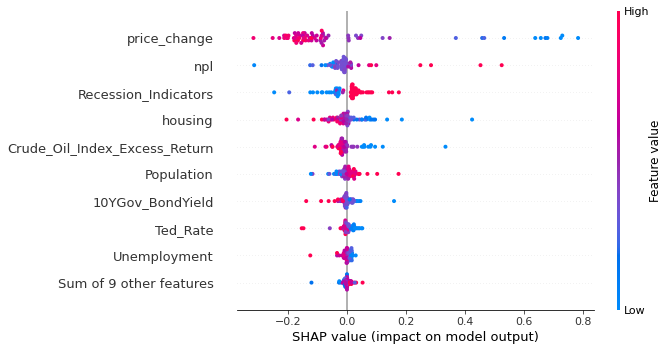

In [63]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

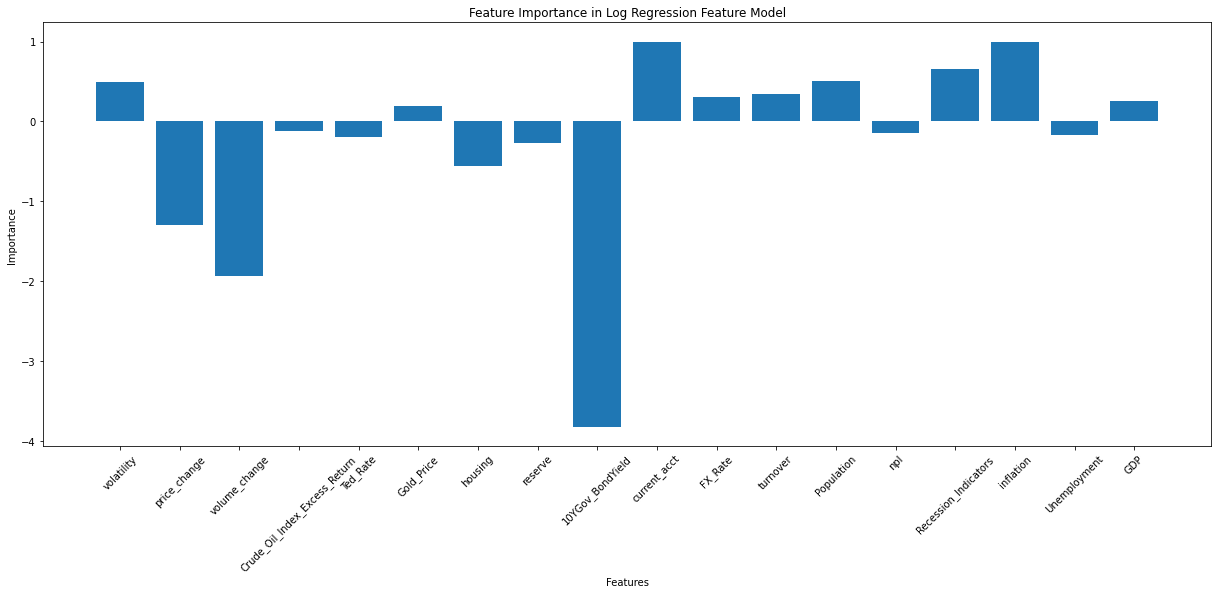

In [64]:
model_name = "Log Regression Feature"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [65]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.7079106372903553


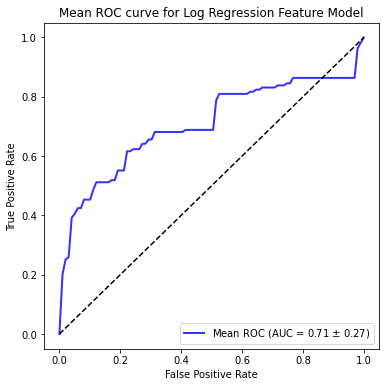

In [66]:
plot_roc_curve(evaluation_df, model_name)